In [1]:
#Package & Data Import

In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from colorsetup import colors, palette
sns.set_palette(palette)

%matplotlib inline
plotsize = (13, 5)

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

import statsmodels as ss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [3]:
#Read data
df = pd.read_excel("Sample - Superstore.xls")
df.shape

(9994, 21)

In [4]:
df.head().T

,0,1,2,3,4
Row ID,1,2,3,4,5
Order ID,CA-2013-152156,CA-2013-152156,CA-2013-138688,US-2012-108966,US-2012-108966
Order Date,2013-11-09 00:00:00,2013-11-09 00:00:00,2013-06-13 00:00:00,2012-10-11 00:00:00,2012-10-11 00:00:00
Ship Date,2013-11-12 00:00:00,2013-11-12 00:00:00,2013-06-17 00:00:00,2012-10-18 00:00:00,2012-10-18 00:00:00
Ship Mode,Second Class,Second Class,Second Class,Standard Class,Standard Class
Customer ID,CG-12520,CG-12520,DV-13045,SO-20335,SO-20335
Customer Name,Claire Gute,Claire Gute,Darrin Van Huff,Sean O'Donnell,Sean O'Donnell
Segment,Consumer,Consumer,Corporate,Consumer,Consumer
Country,United States,United States,United States,United States,United States
City,Henderson,Henderson,Los Angeles,Fort Lauderdale,Fort Lauderdale


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [6]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,"9,994.00","9,994.00","9,994.00","9,994.00","9,994.00","9,994.00"
mean,"4,997.50","55,190.38",229.86,3.79,0.16,28.66
std,"2,885.16","32,063.69",623.25,2.23,0.21,234.26
min,1.00,"1,040.00",0.44,1.00,0.00,"-6,599.98"
25%,"2,499.25","23,223.00",17.28,2.00,0.00,1.73
50%,"4,997.50","56,430.50",54.49,3.00,0.20,8.67
75%,"7,495.75","90,008.00",209.94,5.00,0.20,29.36
max,"9,994.00","99,301.00","22,638.48",14.00,0.80,"8,399.98"


In [7]:
df['Segment'].value_counts().to_frame()

,Segment
Consumer,5191
Corporate,3020
Home Office,1783


In [8]:
df[['Country','Region']].value_counts().to_frame()

0
Country       Region       
United States West     3203
              East     2848
              Central  2323
              South    1620

In [9]:
df.groupby(['Category'])['Sales'].sum().sort_values().to_frame()

,Sales
Category,
Office Supplies,"719,047.03"
Furniture,"741,999.80"
Technology,"836,154.03"


In [10]:
df['Category'].value_counts().to_frame()

,Category
Office Supplies,6026
Furniture,2121
Technology,1847


In [11]:
#Simplify Time Series
variables = ['Order Date', 'Category', 'Sales']
group_variables = variables[:2]
outcome_variable = variables[-1]
base = df.groupby(group_variables)[outcome_variable].sum().reset_index()

In [12]:
base.shape

(2864, 3)

In [13]:
base.dtypes

Order Date    datetime64[ns]
Category              object
Sales                float64
dtype: object

In [14]:
base.head()

,Order Date,Category,Sales
0,2011-01-04,Office Supplies,16.45
1,2011-01-05,Office Supplies,288.06
2,2011-01-06,Office Supplies,19.54
3,2011-01-07,Furniture,"2,573.82"
4,2011-01-07,Office Supplies,685.34


In [15]:
base['Category'].unique()

array(['Office Supplies', 'Furniture', 'Technology'], dtype=object)

In [16]:
print(base['Order Date'].min(), ',', base['Order Date'].max())

2011-01-04 00:00:00 , 2014-12-31 00:00:00


In [17]:
base.set_index('Order Date', inplace=True)

In [18]:
base.head()

,Category,Sales
Order Date,,
2011-01-04,Office Supplies,16.45
2011-01-05,Office Supplies,288.06
2011-01-06,Office Supplies,19.54
2011-01-07,Furniture,"2,573.82"
2011-01-07,Office Supplies,685.34


In [19]:
print(base['2011'].head())
print('\n')

print(base[base['Category'] == 'Office Supplies']['2011':'2012-02'].head())

                   Category    Sales
Order Date                          
2011-01-04  Office Supplies    16.45
2011-01-05  Office Supplies   288.06
2011-01-06  Office Supplies    19.54
2011-01-07        Furniture 2,573.82
2011-01-07  Office Supplies   685.34


                   Category  Sales
Order Date                        
2011-01-04  Office Supplies  16.45
2011-01-05  Office Supplies 288.06
2011-01-06  Office Supplies  19.54
2011-01-07  Office Supplies 685.34
2011-01-08  Office Supplies  10.43


/var/folders/jz/0vshmh6x6pbfhh1c0v8jvx8c0000gn/T/ipykernel_1854/2486256063.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(base['2011'].head())


In [20]:
base.index.dayofweek.unique() #Monday=0, Sunday=6

Int64Index([1, 2, 3, 4, 5, 0, 6], dtype='int64', name='Order Date')

In [21]:
#Data Cleaning

In [22]:
base.reset_index(inplace=True)
sales_pivot = base.pivot(index='Order Date', columns='Category', values='Sales')
sales_pivot.head()

Category,Furniture,Office Supplies,Technology
Order Date,,,
2011-01-04,NaN,16.45,NaN
2011-01-05,NaN,288.06,NaN
2011-01-06,NaN,19.54,NaN
2011-01-07,"2,573.82",685.34,"1,147.94"
2011-01-08,76.73,10.43,NaN


In [23]:
#Impute NaN sales with 0
sales = base.set_index(['Order Date', 'Category']).unstack('Category').fillna(0)
sales.columns = sales.columns.levels[1].rename(None)
sales.head()

,Furniture,Office Supplies,Technology
Order Date,,,
2011-01-04,0.00,16.45,0.00
2011-01-05,0.00,288.06,0.00
2011-01-06,0.00,19.54,0.00
2011-01-07,"2,573.82",685.34,"1,147.94"
2011-01-08,76.73,10.43,0.00


In [24]:
print('\nUnique dates: ', len(sales.index.unique()), 'Days')

orderdate_range = sales.index.max() - sales.index.min()
print('Total days: ', orderdate_range.days + 1, 'Days')


Unique dates:  1238 Days
Total days:  1458 Days


In [25]:
#Get complete date range as index
new_index = pd.date_range(sales.index.min(), sales.index.max())
sales2 = sales.reindex(new_index, fill_value=0)

In [26]:
print('\nUnique dates: ', len(sales2.index.unique()), 'Days')

orderdate_range = sales2.index.max() - sales2.index.min()
print('Total days: ', orderdate_range.days + 1, 'Days')


Unique dates:  1458 Days
Total days:  1458 Days


In [27]:
#Resampling

In [28]:
#Upsamping (grouping to a longer period)
sales_mthly = sales2.resample('M').sum()
sales_qtrly = sales2.resample('Q').sum()
sales_yrly = sales2.resample('Y').sum()

In [29]:
#Downsamping (interpolating to a shorter period)
sales_mthly_from_yrly = sales_yrly.resample('M').interpolate(method='spline', order=3).head()
sales_mthly_from_yrly

,Furniture,Office Supplies,Technology
2011-12-31,"157,192.85","151,776.41","175,278.23"
2012-01-31,"157,062.62","147,084.68","168,957.77"
2012-02-29,"157,200.89","143,355.49","164,096.18"
2012-03-31,"157,611.09","140,049.01","159,969.03"
2012-04-30,"158,251.03","137,493.33","156,975.06"


In [30]:
help(pd.core.resample.DatetimeIndexResampler.interpolate)

Help on function interpolate in module pandas.core.resample:

interpolate(self, method='linear', axis=0, limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None, **kwargs)
    Interpolate values according to different methods.
    
    Fill NaN values using an interpolation method.
    
    Please note that only ``method='linear'`` is supported for
    DataFrame/Series with a MultiIndex.
    
    Parameters
    ----------
    method : str, default 'linear'
        Interpolation technique to use. One of:
    
        * 'linear': Ignore the index and treat the values as equally
          spaced. This is the only method supported on MultiIndexes.
        * 'time': Works on daily and higher resolution data to interpolate
          given length of interval.
        * 'index', 'values': use the actual numerical values of the index.
        * 'pad': Fill in NaNs using existing values.
        * 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
        

In [31]:
#Vairable Transformation

In [32]:
#Variable transformation (log, difference, % change)

print('\nYearly Sales, Cumulative Sums: \n', sales_yrly.cumsum())
print('\nYearly Sales: \n', sales_yrly)
print('\nlog(1 + Yearly Sales): \n', np.log(1+sales_yrly))
print('\nYearly Sales, First Difference: \n', sales_yrly.diff())
print('\nYearly Sales, % Change: \n', sales_yrly.pct_change())


Yearly Sales, Cumulative Sums: 
             Furniture  Office Supplies  Technology
2011-12-31 157,192.85       151,776.41  175,278.23
2012-12-31 327,711.09       289,009.88  338,059.04
2013-12-31 526,612.53       472,520.46  564,120.85
2014-12-31 741,999.80       719,047.03  836,154.03

Yearly Sales: 
             Furniture  Office Supplies  Technology
2011-12-31 157,192.85       151,776.41  175,278.23
2012-12-31 170,518.24       137,233.46  162,780.81
2013-12-31 198,901.44       183,510.59  226,061.80
2014-12-31 215,387.27       246,526.57  272,033.19

log(1 + Yearly Sales): 
             Furniture  Office Supplies  Technology
2011-12-31      11.97            11.93       12.07
2012-12-31      12.05            11.83       12.00
2013-12-31      12.20            12.12       12.33
2014-12-31      12.28            12.42       12.51

Yearly Sales, First Difference: 
             Furniture  Office Supplies  Technology
2011-12-31        NaN              NaN         NaN
2012-12-31  13,325.38

In [33]:
#Rolling Stats
window_size = 4 #qtrs
rolling_window = sales_qtrly.rolling(window_size)

print('\nQuarterly Sales, Rolling 4-Quarter Mean: \n', rolling_window.mean().dropna())
print('\nQuarterly Sales, Rolling 4-Quarter Std Dev: \n', rolling_window.std().dropna())


Quarterly Sales, Rolling 4-Quarter Mean: 
             Furniture  Office Supplies  Technology
2011-12-31  39,298.21        37,944.10   43,819.56
2012-03-31  40,477.70        40,076.78   39,108.38
2012-06-30  40,352.97        40,345.86   39,610.39
2012-09-30  42,260.01        35,805.07   38,900.73
2012-12-31  42,629.56        34,308.37   40,695.20
2013-03-31  41,791.38        35,903.76   45,874.16
2013-06-30  45,016.08        36,460.87   53,653.83
2013-09-30  46,008.97        38,816.15   53,894.38
2013-12-31  49,725.36        45,877.65   56,515.45
2014-03-31  49,576.94        49,370.22   59,746.10
2014-06-30  50,266.67        51,822.33   56,267.58
2014-09-30  51,474.47        58,884.63   61,952.17
2014-12-31  53,846.82        61,631.64   68,008.30

Quarterly Sales, Rolling 4-Quarter Std Dev: 
             Furniture  Office Supplies  Technology
2011-12-31  18,673.83        18,693.65   15,305.34
2012-03-31  17,376.20        15,312.70   20,134.69
2012-06-30  17,496.39        15,113.92   1

In [34]:
#Visualization - Run-Sequence Plots

<AxesSubplot:title={'center':'Quarterly Sales, Rolling 4-Quarter Std Dev'}>

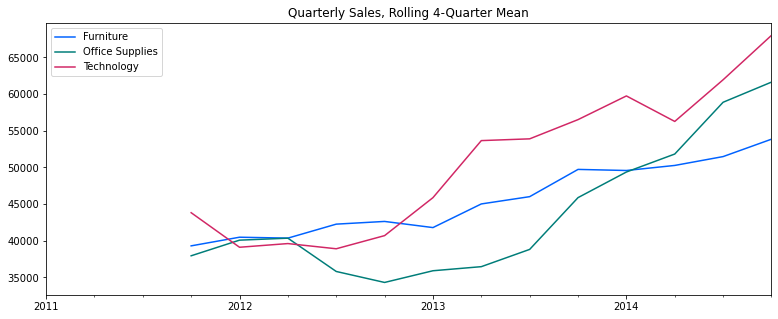

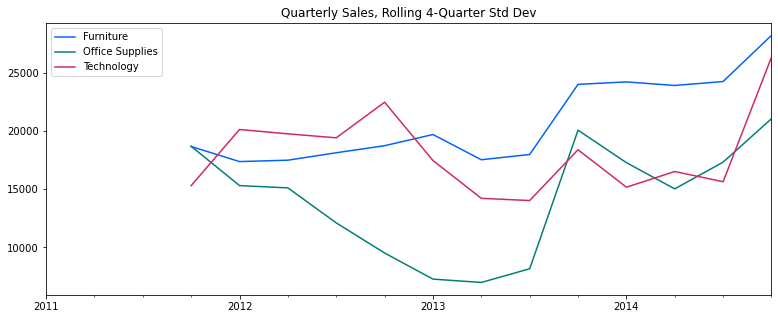

In [35]:
rolling_window.mean().plot(figsize = plotsize, title = 'Quarterly Sales, Rolling 4-Quarter Mean')
rolling_window.std().plot(figsize = plotsize, title = 'Quarterly Sales, Rolling 4-Quarter Std Dev')

<AxesSubplot:title={'center':'Daily Sales'}>

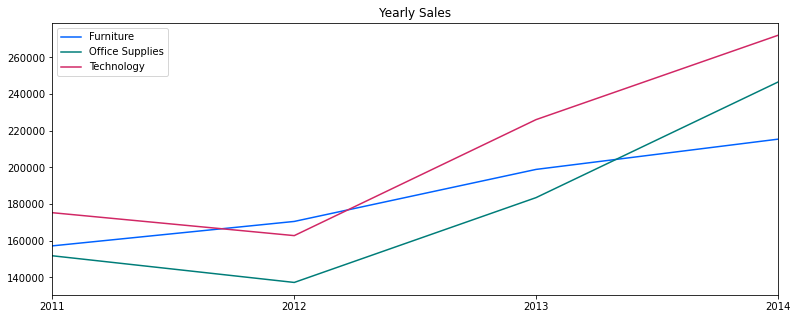

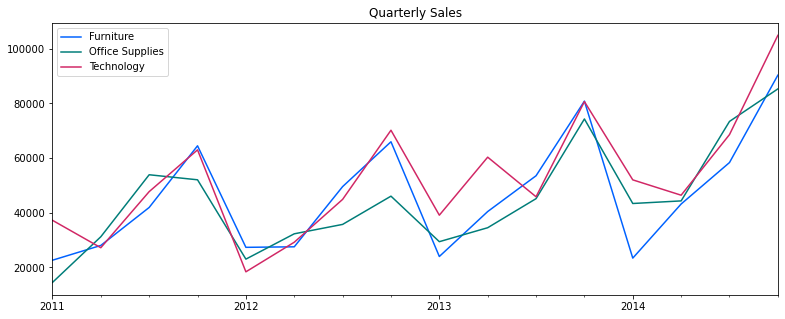

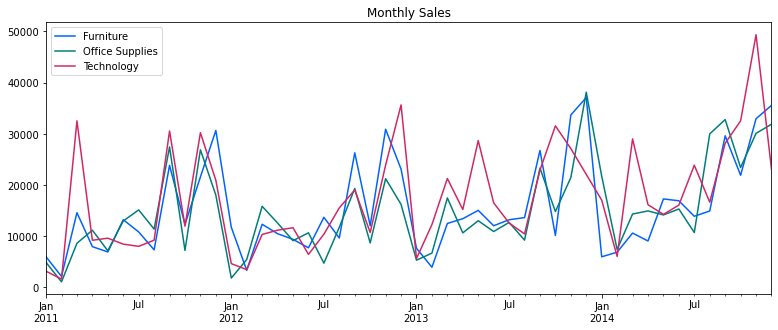

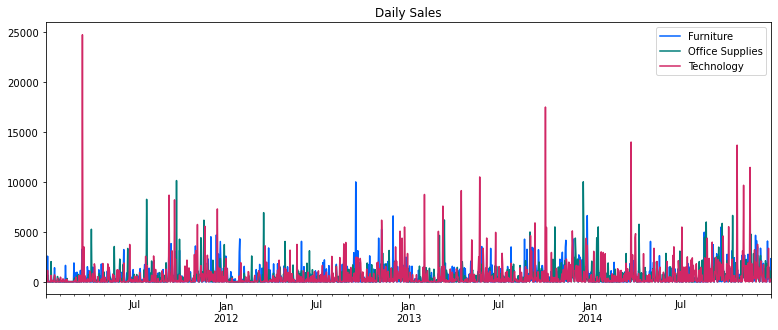

In [36]:
sales_yrly.plot(figsize = plotsize, title = 'Yearly Sales')
sales_qtrly.plot(figsize = plotsize, title = 'Quarterly Sales')
sales_mthly.plot(figsize = plotsize, title = 'Monthly Sales')
sales2.plot(figsize = plotsize, title = 'Daily Sales')

#sales_mthly_from_yrly.plot(figsize = plotsize, title = 'Monthly Sales Downsampled from Yearly')

<AxesSubplot:title={'center':'Monthly Sales, % Change'}>

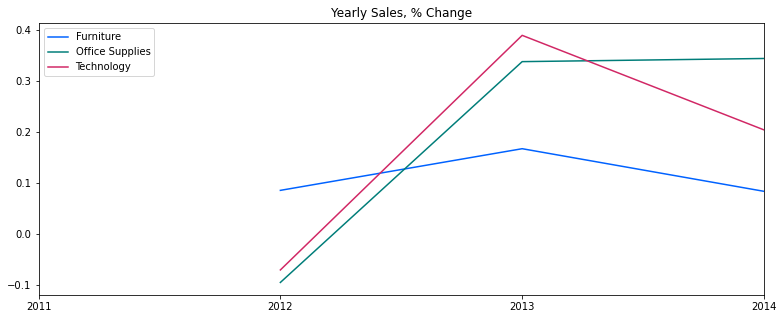

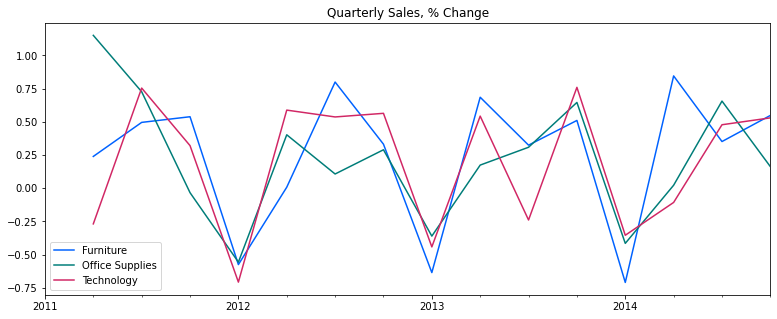

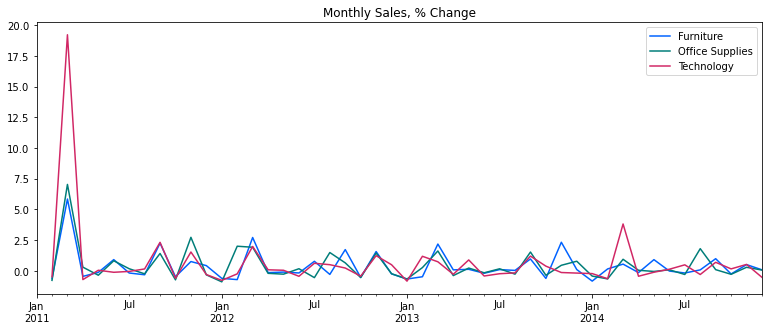

In [37]:
sales_yrly.pct_change().plot(figsize = plotsize, title = 'Yearly Sales, % Change')
sales_qtrly.pct_change().plot(figsize = plotsize, title = 'Quarterly Sales, % Change')
sales_mthly.pct_change().plot(figsize = plotsize, title = 'Monthly Sales, % Change')

<AxesSubplot:title={'center':'Daily Sales, Cumulative Sums'}>

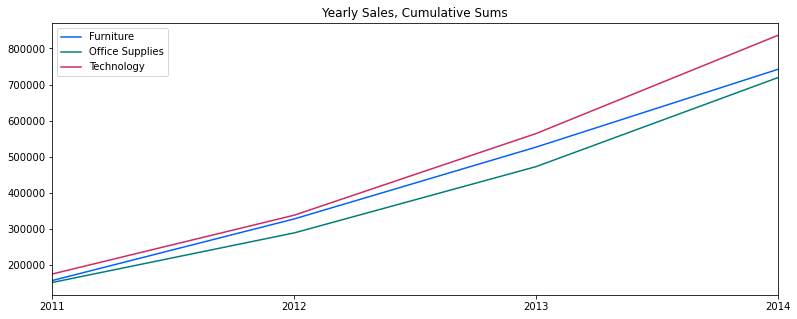

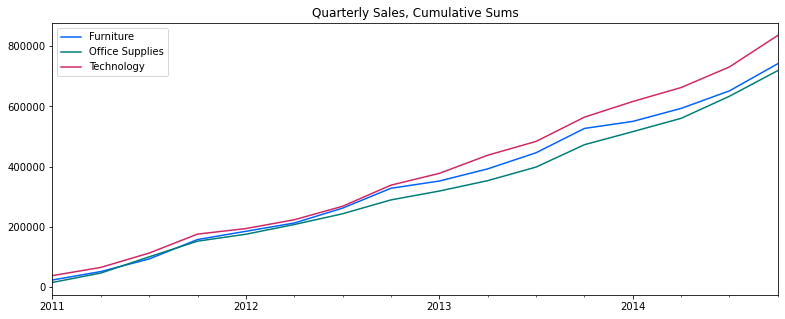

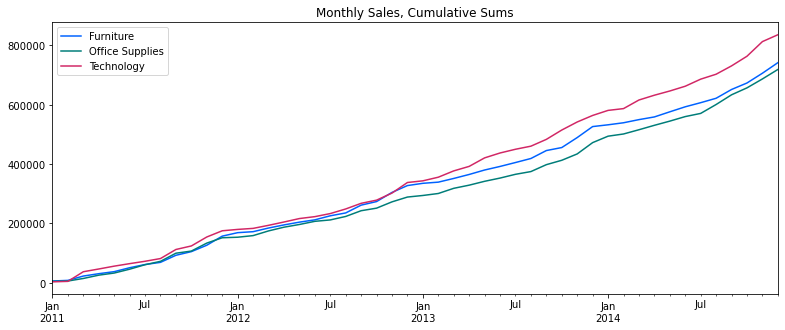

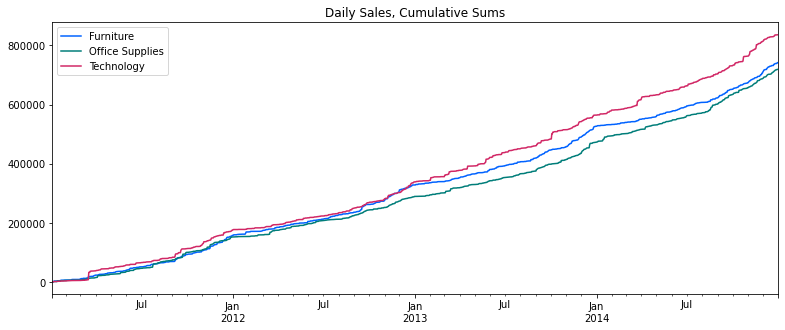

In [38]:
sales_yrly.cumsum().plot(figsize = plotsize, title = 'Yearly Sales, Cumulative Sums')
sales_qtrly.cumsum().plot(figsize = plotsize, title = 'Quarterly Sales, Cumulative Sums')
sales_mthly.cumsum().plot(figsize = plotsize , title = 'Monthly Sales, Cumulative Sums')
sales2.cumsum().plot(figsize = plotsize, title = 'Daily Sales, Cumulative Sums')

In [39]:
#Focus on Mthly Sales on Technology Products
#due to 1)lowest units bring highest sales; 2)growth rate slows down recently

In [40]:
#Visualization - (Partial) Autocorrelation Plots

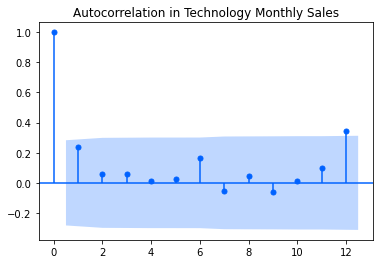

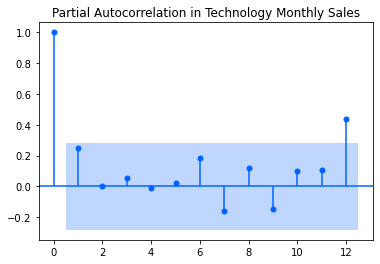

In [41]:
ACF_plot_mthly = plot_acf(sales_mthly['Technology'], lags=12, title='Autocorrelation in Technology Monthly Sales')
PACF_plot_mthly = plot_pacf(sales_mthly['Technology'], lags=12, title='Partial Autocorrelation in Technology Monthly Sales')

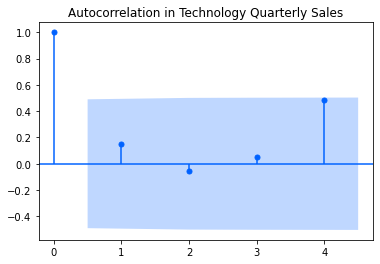

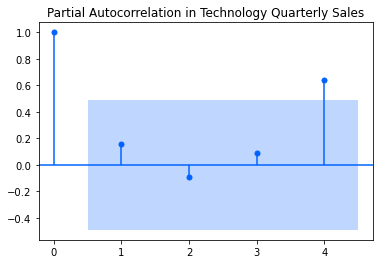

In [42]:
ACF_plot_qtrly = plot_acf(sales_qtrly['Technology'], lags=4, title='Autocorrelation in Technology Quarterly Sales')
PACF_plot_qtrly = plot_pacf(sales_qtrly['Technology'], lags=4, title='Partial Autocorrelation in Technology Quarterly Sales')

In [43]:
#Visualization - Seasonal Plot

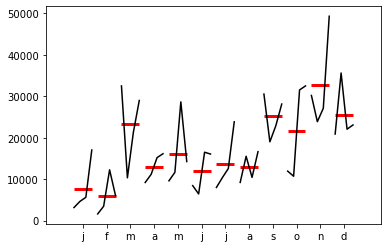

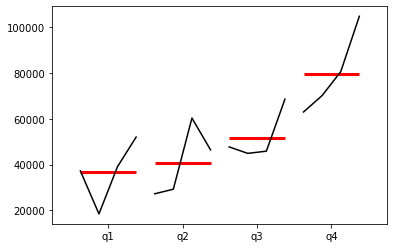

In [44]:
SSNL_plot_mthly = month_plot(sales_mthly['Technology'])
SSNL_plot_qtrly = quarter_plot(sales_qtrly['Technology'])

In [45]:
#Identify Stationarity - Non Stationary

In [46]:
#Run-Sequence Plots
def run_sequence_plot(x, y, title, xlabel='time', ylabel='series'):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)

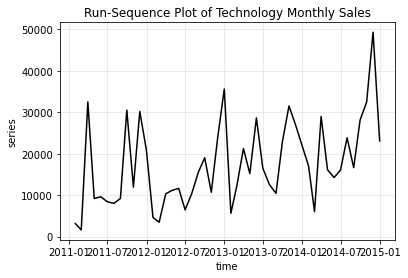

In [47]:
run_sequence_plot(sales_mthly.index, sales_mthly['Technology'], title='Run-Sequence Plot of Technology Monthly Sales')

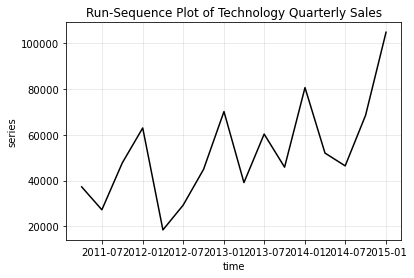

In [48]:
run_sequence_plot(sales_qtrly.index, sales_qtrly['Technology'], title='Run-Sequence Plot of Technology Quarterly Sales')

In [49]:
#Chunked Statistics
chunks = np.split(sales_qtrly['Technology'], indices_or_sections=8)
chunks

[2011-03-31   37,262.97
 2011-06-30   27,231.28
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2011-09-30   47,751.37
 2011-12-31   63,032.62
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2012-03-31   18,418.25
 2012-06-30   29,239.32
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2012-09-30   44,912.73
 2012-12-31   70,210.52
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2013-03-31   39,134.07
 2013-06-30   60,357.99
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2013-09-30   45,874.93
 2013-12-31   80,694.82
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2014-03-31   52,056.67
 2014-06-30   46,443.90
 Freq: Q-DEC, Name: Technology, dtype: float64,
 2014-09-30    68,613.29
 2014-12-31   104,919.33
 Freq: Q-DEC, Name: Technology, dtype: float64]

In [50]:
print("{} | {:6} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i,chunk in enumerate(chunks, 1):
    print("{:5} | {:,.0f} | {:.2}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean   | Variance
--------------------------
    1 | 32,247 | 2.5e+07
    2 | 55,392 | 5.8e+07
    3 | 23,829 | 2.9e+07
    4 | 57,562 | 1.6e+08
    5 | 49,746 | 1.1e+08
    6 | 63,285 | 3e+08
    7 | 49,250 | 7.9e+06
    8 | 86,766 | 3.3e+08


In [51]:
np.mean(chunks, axis=1)

array([32247.1245, 55391.992 , 23828.782 , 57561.6225, 49746.0285,
       63284.8735, 49250.283 , 86766.3105])

In [52]:
np.var(chunks, axis=1)

array([2.51587462e+07, 5.83791657e+07, 2.92738998e+07, 1.59994583e+08,
       1.12613748e+08, 3.03106202e+08, 7.87577993e+06, 3.29531972e+08])

<AxesSubplot:>

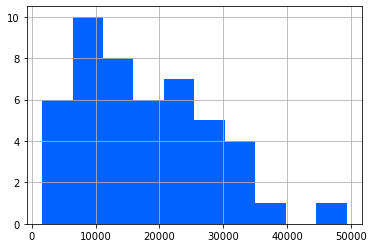

In [53]:
#Histogram Plot
pd.Series(sales_mthly['Technology']).hist(bins=10)

<AxesSubplot:>

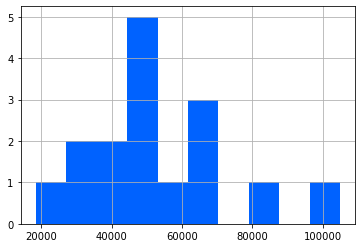

In [54]:
pd.Series(sales_qtrly['Technology']).hist(bins=10)

In [55]:
#Augmented Dickey-Fuller Test (Stationarity Test) - needs obs > 100, for reference only
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(sales_mthly['Technology'])
print('ADF Test Statistic: ', adf)
print('P-Value: ', pvalue)
print('#Observatiosn: ', nobs)
print('Critical Values: ', critical_values)

ADF Test Statistic:  -5.339163036535343
P-Value:  4.5403459109922655e-06
#Observatiosn:  47
Critical Values:  {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


In [56]:
#Stationarity Transformation

In [57]:
#Remove Trend & Seasonality
def decompose_trend_seasonality(data, model_type, ssnl_period):
    ss_decomp = seasonal_decompose(x=data, model=model_type, period=ssnl_period)
    est_trend = ss_decomp.trend
    est_ssnl = ss_decomp.seasonal
    est_residual = ss_decomp.resid
    
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    axes[0].plot(data, label='Original')
    axes[0].legend(loc='upper left')
    
    axes[1].plot(est_trend, label='Trend')
    axes[1].legend(loc='upper left')
    
    axes[2].plot(est_ssnl, label='Seasonality')
    axes[2].legend(loc='upper left')
    
    axes[3].plot(est_residual, label='Residual')
    axes[3].legend(loc='upper left')

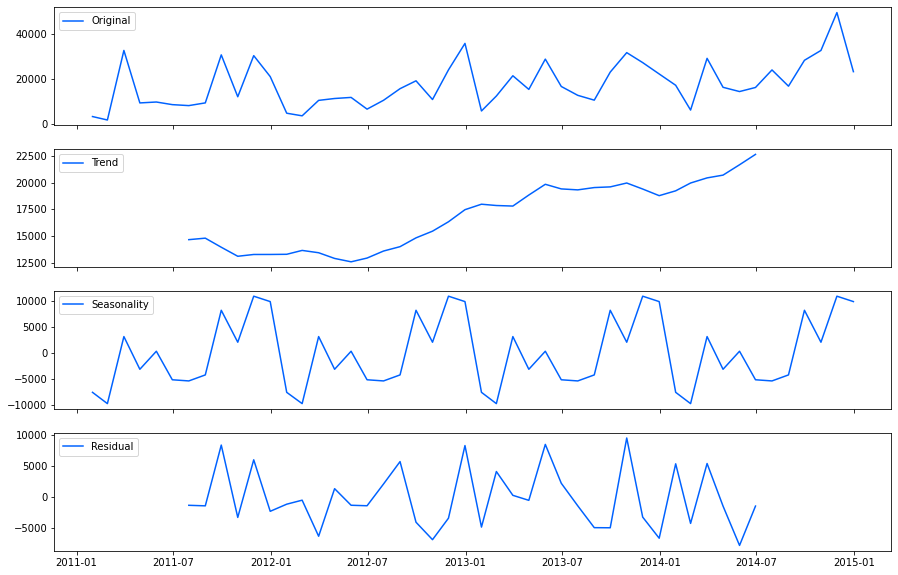

In [58]:
decompose_trend_seasonality(sales_mthly['Technology'],'additive', 12) 

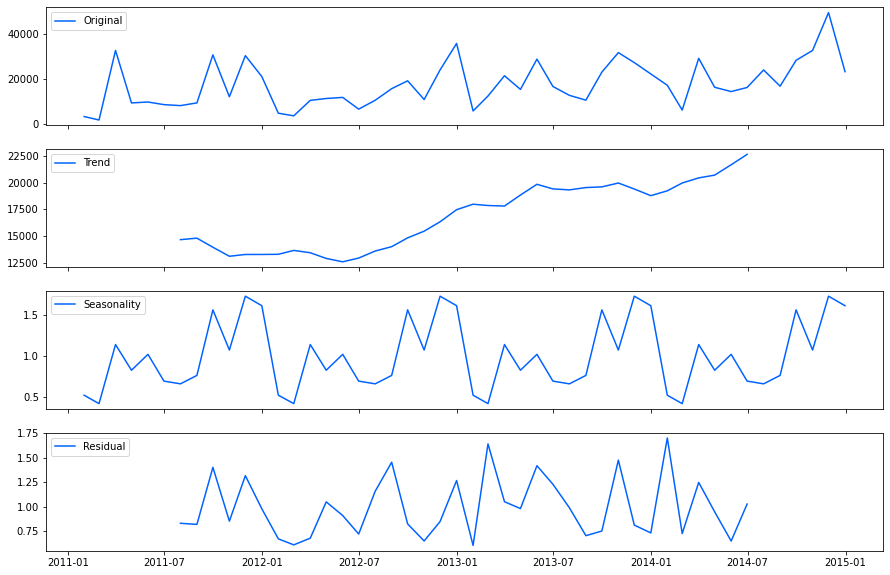

In [59]:
decompose_trend_seasonality(sales_mthly['Technology'],'multiplicative', 12) #best

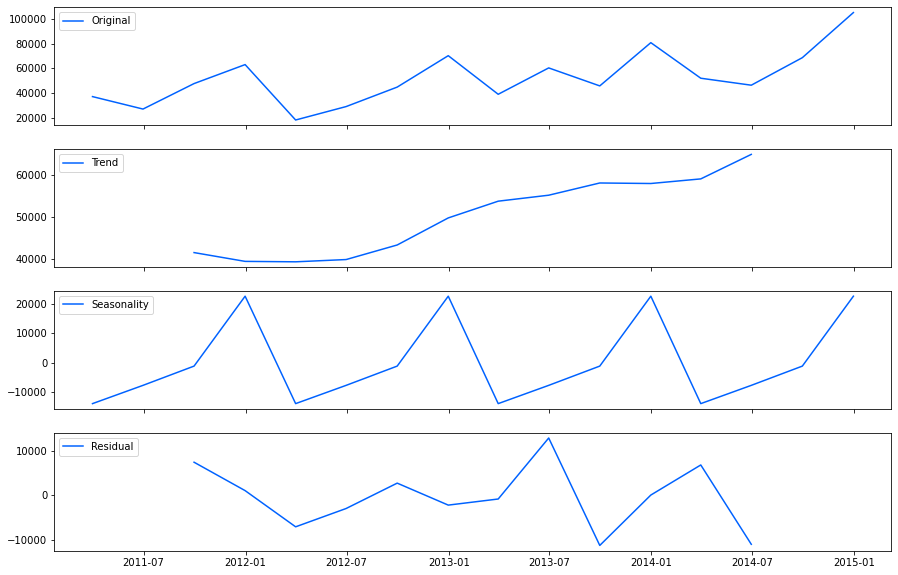

In [60]:
decompose_trend_seasonality(sales_qtrly['Technology'],'additive', 4)

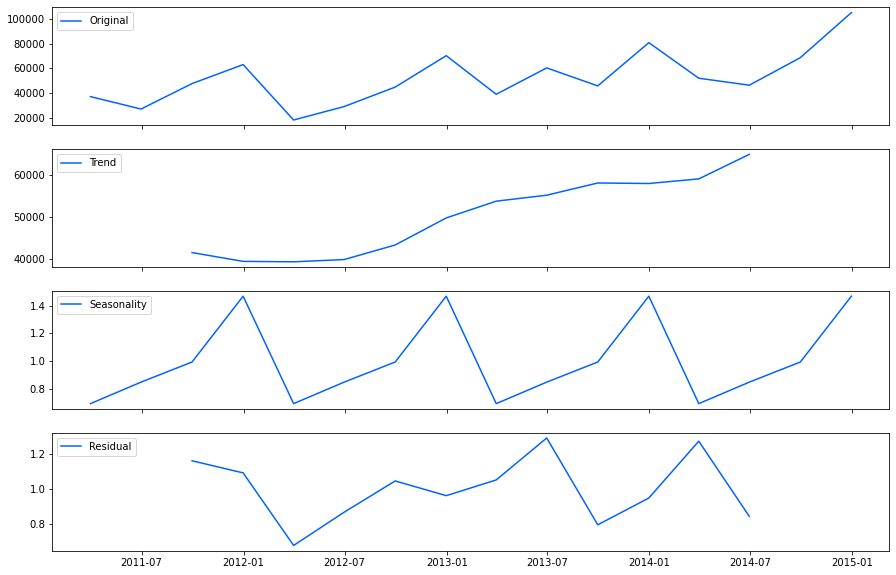

In [61]:
decompose_trend_seasonality(sales_qtrly['Technology'],'multiplicative', 4)

In [62]:
#Use Mthly Sales Data for Additive Model

In [63]:
ss_decomp = seasonal_decompose(x=sales_mthly['Technology'], model='multiplicative', period=12)
est_trend = ss_decomp.trend
est_ssnl = ss_decomp.seasonal
est_residual = ss_decomp.resid

<AxesSubplot:>

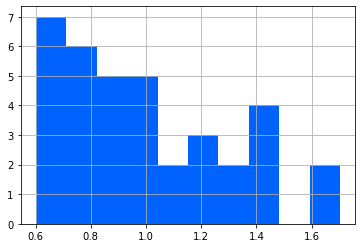

In [64]:
#Histogram Plot on Residuals
pd.Series(est_residual).hist() 

In [65]:
#Chunked Statistics Revisited on Residuals
chunks = np.split(est_residual, indices_or_sections=12)
print("{} | {:4} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 24)
for i,chunk in enumerate(chunks, 1):
    print("{:5} | {:,.1f} | {:.2f}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean | Variance
------------------------
    1 | nan | nan
    2 | 0.8 | 0.00
    3 | 1.1 | 0.05
    4 | 0.7 | 0.03
    5 | 1.1 | 0.08
    6 | 0.9 | 0.05
    7 | 1.1 | 0.14
    8 | 1.1 | 0.07
    9 | 0.9 | 0.10
   10 | 1.2 | 0.13
   11 | 0.8 | 0.04
   12 | nan | nan


In [66]:
#Remove Heteroscedasticity with Log
est_residual.describe().to_frame().T #all postive values, otw all values + min to allow log

,count,mean,std,min,25%,50%,75%,max
resid,36.00,0.99,0.31,0.60,0.73,0.93,1.23,1.70


In [67]:
sales_mthlyresiduals = est_residual.to_frame()
sales_mthlyresiduals.head(12)

,resid
2011-01-31,NaN
2011-02-28,NaN
2011-03-31,NaN
2011-04-30,NaN
2011-05-31,NaN
2011-06-30,NaN
2011-07-31,0.83
2011-08-31,0.82
2011-09-30,1.40
2011-10-31,0.85


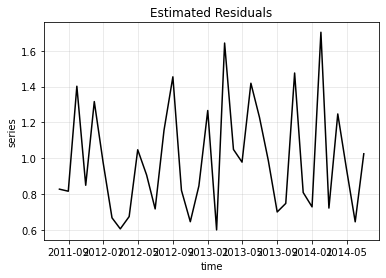

In [68]:
run_sequence_plot(sales_mthlyresiduals.index, sales_mthlyresiduals['resid'], title='Estimated Residuals')

array([[<AxesSubplot:title={'center':'resid'}>]], dtype=object)

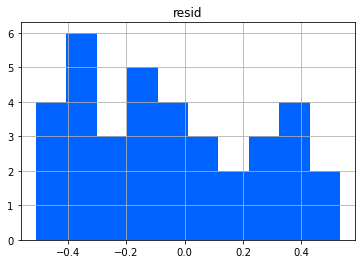

In [69]:
log_sales_mthlyresiduals = np.log(sales_mthlyresiduals)
log_sales_mthlyresiduals.hist()

In [70]:
#Chunked Statistics Revisited on Log(Residuals)
chunks = np.split(log_sales_mthlyresiduals['resid'], indices_or_sections=12)
print("{} | {:5} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 24)
for i,chunk in enumerate(chunks, 1):
    print("{:5} | {:,.2f} | {:.2f}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean  | Variance
------------------------
    1 | nan | nan
    2 | -0.20 | 0.00
    3 | 0.11 | 0.04
    4 | -0.31 | 0.04
    5 | 0.02 | 0.07
    6 | -0.14 | 0.06
    7 | 0.00 | 0.13
    8 | 0.05 | 0.07
    9 | -0.11 | 0.08
   10 | 0.09 | 0.10
   11 | -0.21 | 0.05
   12 | nan | nan


In [71]:
#Remove Autocorrelation with Differencing - NOT NEEDED!
difference = log_sales_mthlyresiduals['resid'][:-1] - log_sales_mthlyresiduals['resid'][1:]
pd.DataFrame({'Original':log_sales_mthlyresiduals['resid'][:-1],
              'Shift': log_sales_mthlyresiduals['resid'][1:]})

,Original,Shift
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-30,NaN,NaN
2011-05-31,NaN,NaN
2011-06-30,NaN,NaN
2011-07-31,-0.19,-0.19
2011-08-31,-0.20,-0.20
2011-09-30,0.34,0.34
2011-10-31,-0.16,-0.16


In [72]:
#Time Series Models - Last 6 mths as Test Set

In [73]:
log_resid = log_sales_mthlyresiduals['resid'].to_frame().fillna(0)[:-6]
log_resid

,resid
2011-01-31,0.00
2011-02-28,0.00
2011-03-31,0.00
2011-04-30,0.00
2011-05-31,0.00
2011-06-30,0.00
2011-07-31,-0.19
2011-08-31,-0.20
2011-09-30,0.34
2011-10-31,-0.16


In [74]:
#Smoothed Models

In [75]:
def MSE(observations, estimates):
    error = observations - estimates
    squared_error = error ** 2
    mse = sum(squared_error) / len(observations)
    
    return mse

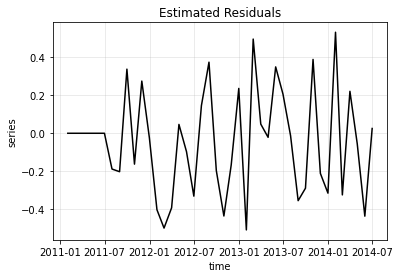

In [76]:
run_sequence_plot(log_resid.index, log_resid, title='Estimated Residuals')

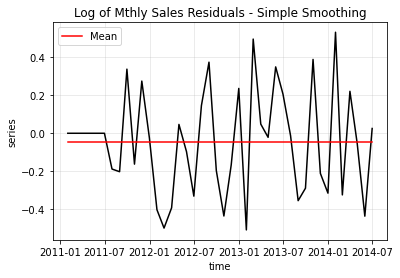

In [77]:
#Simple Smoothing - Residuals
resid_mean = np.mean(log_resid)

resid_mean_curve = np.full(shape=len(log_resid), fill_value=resid_mean, dtype='float')
resid_mean_pred = np.full(shape=6, fill_value=resid_mean, dtype='float')

run_sequence_plot(log_resid.index, log_resid, title='Log of Mthly Sales Residuals - Simple Smoothing')
plt.plot(log_resid.index, resid_mean_curve, 'r', label='Mean')
plt.legend()

In [78]:
MSE(log_resid['resid'], resid_mean_curve)

0.0756295803008201

In [79]:
#Moving Average Smoothing - Trend & Seasonality
trend = np.array(est_trend.to_frame()['trend'].fillna(0)[6:-6])
ssnl = np.array(est_ssnl.to_frame()['seasonal'][:-6])

In [80]:
def moving_average(observations, window=3, forecast=False):
    cum_sum = np.cumsum(observations)
    cum_sum[window:] = cum_sum[window:] - cum_sum[:-window]
    
    if forecast:
        return np.insert(cum_sum[window+1:]/window, 0, np.zeros(3))
    else:
        return cum_sum[window-2:]/window

In [81]:
trend_smth_curve = moving_average(trend, window=3, forecast=False)
ssnl_smth_curve = moving_average(ssnl, window=3, forecast=False)

Text(0.5, 1.0, 'Moving Averge Smoothing - Trend')

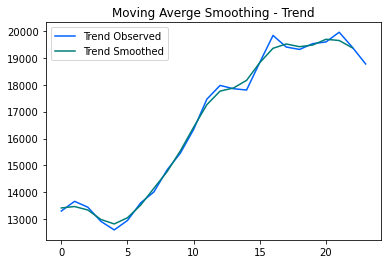

In [82]:
plt.plot(trend[6:-6],label='Trend Observed')
plt.plot(trend_smth_curve[6:-6],label='Trend Smoothed')
plt.legend()
plt.title("Moving Averge Smoothing - Trend")

Text(0.5, 1.0, 'Moving Average Smoothing - Seasonality')

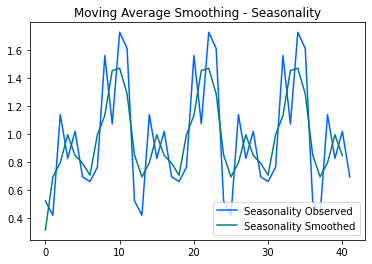

In [83]:
plt.plot(ssnl, label='Seasonality Observed')
plt.plot(ssnl_smth_curve, label='Seasonality Smoothed')
plt.legend()
plt.title("Moving Average Smoothing - Seasonality")

In [84]:
#Double Exponential Smoothing - Trend
single_trend = SimpleExpSmoothing(trend).fit(optimized=True)
single_trend_pred = single_trend.forecast(6)

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [85]:
double_trend = Holt(trend).fit(optimized=True)
double_trend_pred = double_trend.forecast(6)

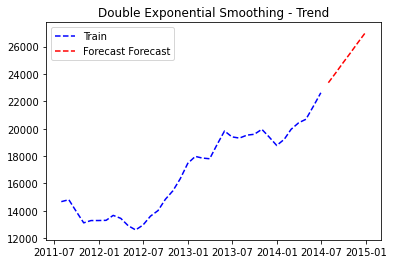

In [86]:
plt.plot(est_trend.index[6:-6], est_trend[6:-6], color='blue', linestyle='--', label='Train')
#plt.plot(est_trend.index[-6:], est_trend[-6:], color='black', linestyle='--', label='Test')
#plt.plot(est_trend.index[-6:], single_trend_pred, color='orange', linestyle='--', label='Single Forecast')
plt.plot(est_trend.index[-6:], double_trend_pred, color='red', linestyle='--', label='Forecast Forecast')
plt.title("Double Exponential Smoothing - Trend")
plt.legend()

In [87]:
#Triple Exponetial Smoothing - Seasonality
single_ssnl = SimpleExpSmoothing(ssnl).fit(optimized=True)
single_ssnl_pred = single_ssnl.forecast(6)
single_ssnl_MSE = MSE(est_ssnl[-6:], single_ssnl_pred)
single_ssnl_MSE

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


0.248618563782841

In [88]:
double_ssnl = Holt(ssnl).fit(optimized=True)
double_ssnl_pred = double_ssnl.forecast(6)
double_ssnl_MSE = MSE(est_ssnl[-6:], double_ssnl_pred)
double_ssnl_MSE

0.21742896529012098

In [89]:
triple_ssnl = ExponentialSmoothing(ssnl, 
                                   trend='multiplicative', 
                                   seasonal='multiplicative', 
                                   seasonal_periods=12).fit(optimized=True)
triple_ssnl_pred = triple_ssnl.forecast(6)
triple_ssnl_MSE = MSE(est_ssnl[-6:], triple_ssnl_pred)
triple_ssnl_MSE

6.162975822039155e-32

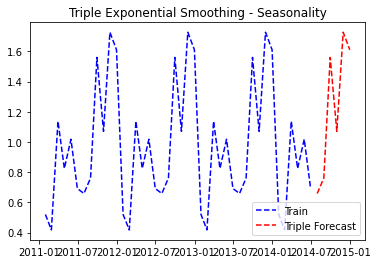

In [90]:
plt.plot(est_ssnl.index[:-6], est_ssnl[:-6], color='blue', linestyle='--', label='Train')
#plt.plot(est_ssnl.index[-6:], est_ssnl[-6:], color='black', linestyle='--', label='Test')
#plt.plot(est_ssnl.index[-6:], single_ssnl_pred, color='green', linestyle='--', label='Single Forecast')
#plt.plot(est_ssnl.index[-6:], double_ssnl_pred, color='orange', linestyle='--', label='Double Forecast')
plt.plot(est_ssnl.index[-6:], triple_ssnl_pred, color='red', linestyle='--', label='Triple Forecast')
plt.title("Triple Exponential Smoothing - Seasonality")
plt.legend()

In [91]:
train = np.array(sales_mthly['Technology'][:-6])
test = np.array(sales_mthly['Technology'][-6:])
pred = double_trend_pred * triple_ssnl_pred * np.exp(resid_mean_pred)
MSE(test, pred)

96970226.84924667

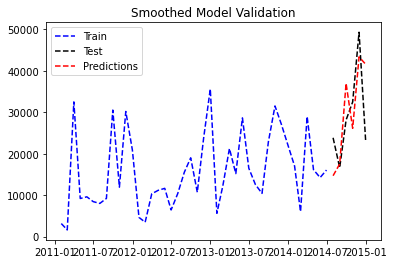

In [92]:
plt.plot(sales_mthly['Technology'].index[:-6], train, color='blue', linestyle='--', label='Train')
plt.plot(sales_mthly['Technology'].index[-6:], test, color='black', linestyle='--', label='Test')
plt.plot(sales_mthly['Technology'].index[-6:], pred, color='red', linestyle='--', label='Predictions')
plt.title("Smoothed Model Validation")
plt.legend()

In [93]:
#ARMA Model

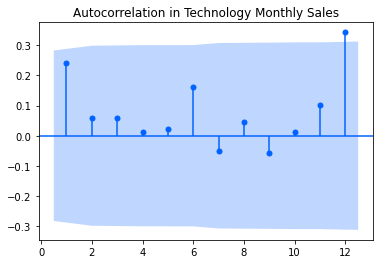

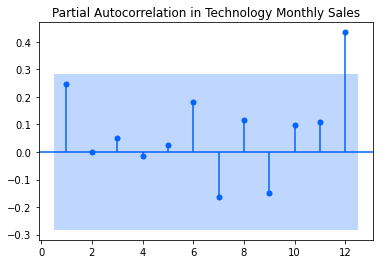

In [94]:
fig = plot_acf(sales_mthly['Technology'], lags=range(1,13), title='Autocorrelation in Technology Monthly Sales')
fig = plot_pacf(sales_mthly['Technology'], lags=range(1,13), title='Partial Autocorrelation in Technology Monthly Sales')

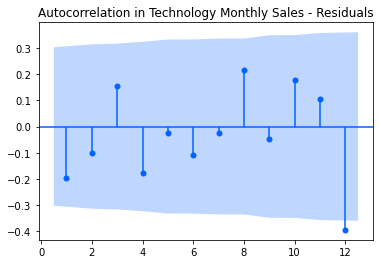

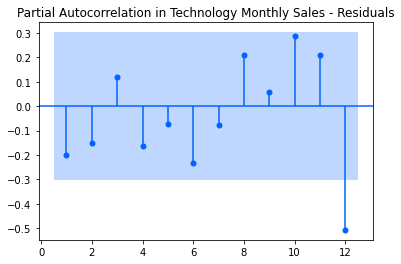

In [95]:
fig = plot_acf(np.exp(log_resid), lags=range(1,13), title='Autocorrelation in Technology Monthly Sales - Residuals')
fig = plot_pacf(np.exp(log_resid), lags=range(1,13), title='Partial Autocorrelation in Technology Monthly Sales - Residuals')

In [96]:
help(sm.tsa.ARMA)

Help on class ARMA in module statsmodels.tsa.arima_model:

class ARMA(statsmodels.tsa.base.tsa_model.TimeSeriesModel)
 |  ARMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Moving Average ARMA(p,q) Model
 |  
 |  .. deprecated:: 0.12
 |     Use statsmodels.tsa.arima.model.ARIMA instead
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,q) order of the model for the number of AR parameters,
 |      and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |

In [97]:
AR_model = sm.tsa.ARMA(sales_mthly['Technology'][:-6], (12,0)).fit(trend='nc',disp=0)
AR_model.params

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ar.L1.Technology     0.26
ar.L2.Technology    -0.10
ar.L3.Technology     0.17
ar.L4.Technology    -0.09
ar.L5.Technology     0.15
ar.L6.Technology     0.21
ar.L7.Technology    -0.21
ar.L8.Technology     0.17
ar.L9.Technology    -0.16
ar.L10.Technology    0.18
ar.L11.Technology   -0.12
ar.L12.Technology    0.52
dtype: float64

In [98]:
MA_model = sm.tsa.ARMA(sales_mthly['Technology'][:-6], (0,12)).fit(trend='nc', disp=0)
MA_model.params

ma.L1.Technology    0.62
ma.L2.Technology    0.28
ma.L3.Technology    0.49
ma.L4.Technology    0.35
ma.L5.Technology    0.31
ma.L6.Technology    0.75
ma.L7.Technology    0.15
ma.L8.Technology    0.41
ma.L9.Technology    0.22
ma.L10.Technology   0.03
ma.L11.Technology   0.14
ma.L12.Technology   0.26
dtype: float64

In [99]:
ARMA_model = sm.tsa.ARMA(sales_mthly['Technology'][:-6], (12,0)).fit(trend='nc', disp=0)
ARMA_model.params

ar.L1.Technology     0.26
ar.L2.Technology    -0.10
ar.L3.Technology     0.17
ar.L4.Technology    -0.09
ar.L5.Technology     0.15
ar.L6.Technology     0.21
ar.L7.Technology    -0.21
ar.L8.Technology     0.17
ar.L9.Technology    -0.16
ar.L10.Technology    0.18
ar.L11.Technology   -0.12
ar.L12.Technology    0.52
dtype: float64

In [100]:
exp_model = sm.tsa.ARMA(sales_mthly['Technology'][:-6], (12,1)).fit(trend='nc', disp=0)
exp_model.params

ar.L1.Technology     0.38
ar.L2.Technology    -0.13
ar.L3.Technology     0.17
ar.L4.Technology    -0.10
ar.L5.Technology     0.15
ar.L6.Technology     0.20
ar.L7.Technology    -0.26
ar.L8.Technology     0.19
ar.L9.Technology    -0.18
ar.L10.Technology    0.19
ar.L11.Technology   -0.14
ar.L12.Technology    0.53
ma.L1.Technology    -0.17
dtype: float64

In [101]:
ARMA_pred = ARMA_model.predict(start='2014-07-31', end='2014-12-31')

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


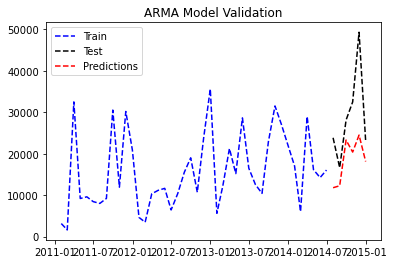

In [102]:
plt.plot(sales_mthly['Technology'].index[:-6], train, color='blue', linestyle='--', label='Train')
plt.plot(sales_mthly['Technology'].index[-6:], test, color='black', linestyle='--', label='Test')
plt.plot(sales_mthly['Technology'].index[-6:], ARMA_pred, color='red', linestyle='--', label='Predictions')
plt.title("ARMA Model Validation")
plt.legend()

In [103]:
train = np.array(sales_mthly['Technology'][:-6])
test = np.array(sales_mthly['Technology'][-6:])
MSE(test, ARMA_pred)

162523562.0674827

In [104]:
#SARMA Model

In [105]:
help(sm.tsa.statespace.SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
 |  
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA p

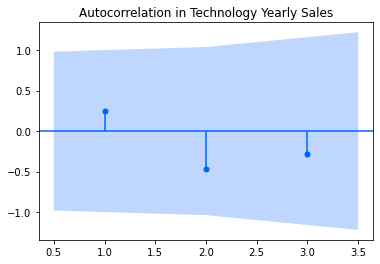

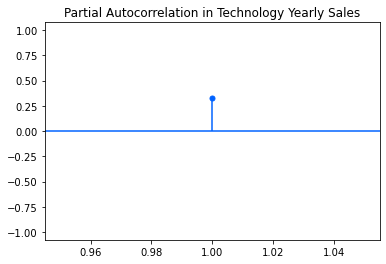

In [106]:
fig = plot_acf(sales_yrly['Technology'], lags=range(1,4), title='Autocorrelation in Technology Yearly Sales')
fig = plot_pacf(sales_yrly['Technology'], lags=range(1,2), title='Partial Autocorrelation in Technology Yearly Sales')

In [107]:
SARIMA_model = sm.tsa.statespace.SARIMAX(sales_mthly['Technology'][:-6], 
                                        order=(12,0,0),
                                        seasonal_order=(0,1,0,12),
                                        trend='c').fit()
SARIMA_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19324D+00    |proj g|=  4.05317D+00


/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  7.33869D+00    |proj g|=  4.06093D-01

At iterate   10    f=  7.25505D+00    |proj g|=  2.48866D-01

At iterate   15    f=  7.23837D+00    |proj g|=  1.04060D-01

At iterate   20    f=  7.23118D+00    |proj g|=  6.22956D-02

At iterate   25    f=  7.22890D+00    |proj g|=  4.16260D-02

At iterate   30    f=  7.22821D+00    |proj g|=  1.39457D-02

At iterate   35    f=  7.22812D+00    |proj g|=  1.65948D-02

At iterate   40    f=  7.22783D+00    |proj g|=  2.28595D-02

At iterate   45    f=  7.22773D+00    |proj g|=  1.05084D-02

At iterate   50    f=  7.22747D+00    |proj g|=  5.43074D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Technology   No. Observations:                   42
Model:             SARIMAX(12, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -303.554
Date:                             Fri, 08 Jul 2022   AIC                            635.107
Time:                                     21:59:26   BIC                            654.724
Sample:                                 01-31-2011   HQIC                           641.383
                                      - 06-30-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9521.1773   1672.884      5.691      0.000    6242.385    1.28e+04
ar.L1         -0.2152      0.132     -1.637      0.102      -0.473       0.043
ar.L2         -0.1245      0.142     -0.875      0.382      -0.403       0.154
ar.L3         -0.1929      0.133     -1.448      0.148      -0.454       0.068
ar.L4         -0.0073      0.141     -0.052      0.959      -0.284       0.269
ar.L5          0.0515      0.095      0.542      0.588      -0.135       0.238
ar.L6         -0.1027      0.123     -0.833      0.405      -0.344       0.139
ar.L7         -0.1013      0.095     -1.064      0.287      -0.288       0.085
ar.L8         -0.0484      0.122     -0.398      0.691      -0.287       0.190
ar.L9         -0.2636      0.075     -3.492      0.000      -0.412      -0.116
ar.L10         0.2023      0.127      1.588      0.112      -0.047       0.452
ar.L11        -0.0449      0.102     -0.439      0.660      -0.245       0.155
ar.L12        -0.6272      0.098     -6.412      0.000      -0.819      -0.435
sigma2      2.099e+07      0.134   1.57e+08      0.000     2.1e+07     2.1e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.70   Prob(JB):                         0.81
Heteroskedasticity (H):               1.18   Skew:                             0.28
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.81e+24. Standard errors may be unstable.
"""

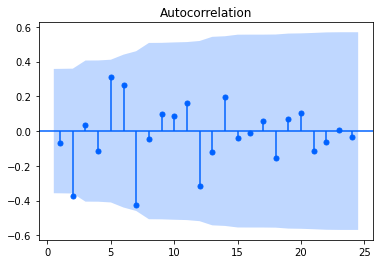

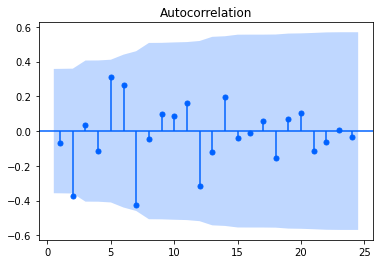

In [108]:
plot_acf(SARIMA_model.resid[SARIMA_model.loglikelihood_burn:], lags=range(1,25))

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


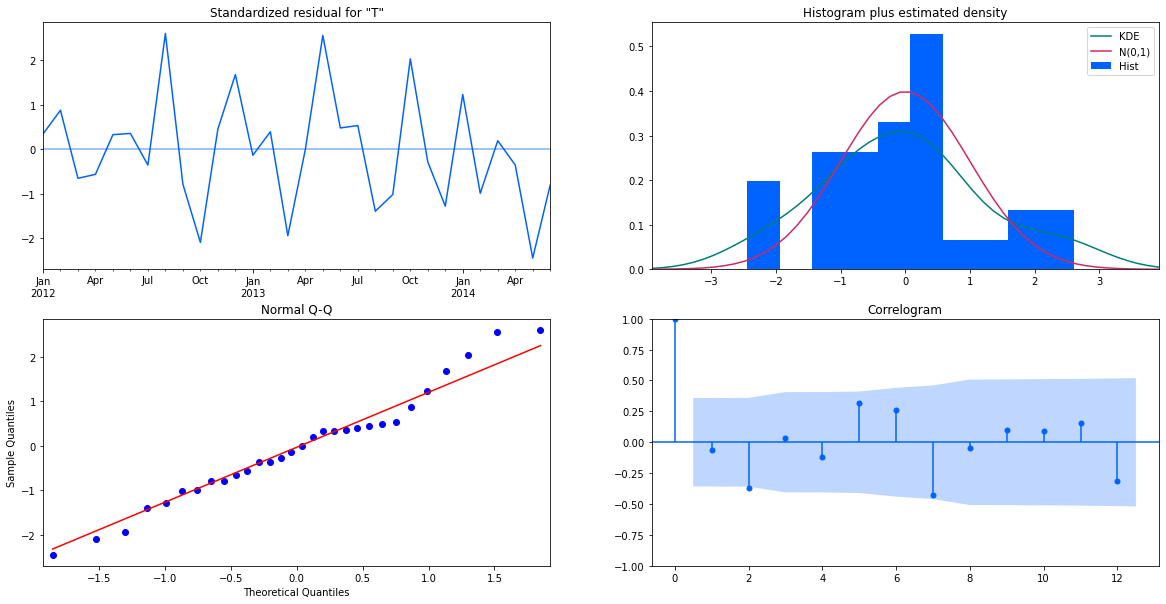

In [109]:
plots = SARIMA_model.plot_diagnostics(lags=12, figsize=(20,10),)

In [110]:
SARIMA_pred = SARIMA_model.predict(start='2014-07-31', end='2014-12-31')

/Users/lillycorsair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


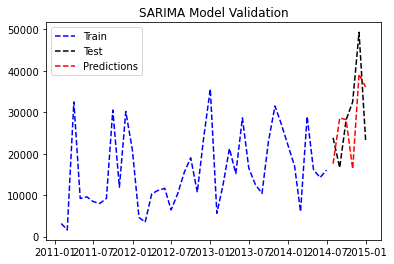

In [111]:
plt.plot(sales_mthly['Technology'].index[:-6], train, color='blue', linestyle='--', label='Train')
plt.plot(sales_mthly['Technology'].index[-6:], test, color='black', linestyle='--', label='Test')
plt.plot(sales_mthly['Technology'].index[-6:], SARIMA_pred, color='red', linestyle='--', label='Predictions')
plt.title("SARIMA Model Validation")
plt.legend()

In [112]:
train = np.array(sales_mthly['Technology'][:-6])
test = np.array(sales_mthly['Technology'][-6:])
MSE(test, SARIMA_pred)

119189924.77096868

In [113]:
#Model Comparison

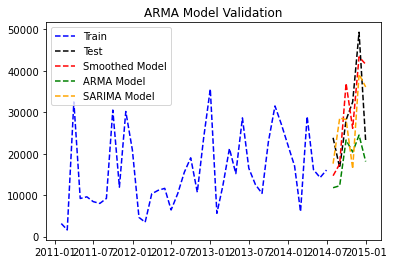

In [114]:
plt.plot(sales_mthly['Technology'].index[:-6], train, color='blue', linestyle='--', label='Train')
plt.plot(sales_mthly['Technology'].index[-6:], test, color='black', linestyle='--', label='Test')
plt.plot(sales_mthly['Technology'].index[-6:], pred, color='red', linestyle='--', label='Smoothed Model')
plt.plot(sales_mthly['Technology'].index[-6:], ARMA_pred, color='green', linestyle='--', label='ARMA Model')
plt.plot(sales_mthly['Technology'].index[-6:], SARIMA_pred, color='orange', linestyle='--', label='SARIMA Model')
plt.title("ARMA Model Validation")
plt.legend()

In [115]:
print('MSE - Smoothed Model: ', round(MSE(test,pred)))
print('MSE - ARMA Model: ', round(MSE(test, ARMA_pred)))
print('MSE - SARIMA Model: ', round(MSE(test,SARIMA_pred)))

MSE - Smoothed Model:  96970227
MSE - ARMA Model:  162523562
MSE - SARIMA Model:  119189925
